# Mushroom Classification Using Different Classifiers (Project Work)

In this notebook, we explore the Secondary Mushroom dataset and build machine learning models to predict whether a mushroom is **edible** or **poisonous** from its observed characteristics (e.g., cap size/shape/color, gill properties, odor, habitat, and related attributes).

The dataset (`secondary_data.csv`, read with `;` as the separator) contains **61,069 samples** and **20 input features**, most of which are categorical, along with three continuous numerical measurements: **cap-diameter**, **stem-height**, and **stem-width**. Using **Spark ML**, we preprocess the data (handle missing values and encode categorical features) and then train and compare three classifiers—**Logistic Regression**, **Linear Support Vector Machine (Linear SVM)**, and **Naive Bayes**—evaluating their performance on a held-out test set.


## 1. Importing the packages

In [1]:
# Spark Core
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Spark ML: preprocessing and pipelines
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, OneHotEncoderModel,
    VectorAssembler, Imputer, StandardScaler
)
from pyspark.ml.stat import Correlation
from pyspark.ml.functions import vector_to_array

# Spark ML: models (Linear/Probabilistic trio)
from pyspark.ml.classification import (
    LogisticRegression, NaiveBayes, LinearSVC, NaiveBayesModel
)

# Spark ML: evaluation & tuning
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import os, urllib.request, zipfile
import numpy as np


## 2. Download and Read the CSV File

In this step, we start a Spark session, download the Secondary Mushroom Dataset from the UCI repository, and extract the nested ZIP files to access `secondary_data.csv`. Finally, we load the CSV into a **Spark DataFrame** using `;` as the separator (with header and automatic schema inference) and print the dataset size (rows and columns) to confirm the import was successful.


In [2]:
# Spark session
spark = SparkSession.builder.appName("MushroomClassification").getOrCreate()

In [3]:
# Download the outer zip
url = "https://archive.ics.uci.edu/static/public/848/secondary+mushroom+dataset.zip"
workdir = "/content/mushroom_data"
os.makedirs(workdir, exist_ok=True)

outer_zip = os.path.join(workdir, "secondary_mushroom_dataset.zip")
if not os.path.exists(outer_zip):
    urllib.request.urlretrieve(url, outer_zip)

# 2) Unzip outer zip -> contains MushroomDataset.zip
outer_dir = os.path.join(workdir, "outer")
os.makedirs(outer_dir, exist_ok=True)
with zipfile.ZipFile(outer_zip, "r") as z:
    z.extractall(outer_dir)

inner_zip = os.path.join(outer_dir, "MushroomDataset.zip")

# 3) Unzip inner zip -> contains MushroomDataset/secondary_data.csv
inner_dir = os.path.join(workdir, "inner")
os.makedirs(inner_dir, exist_ok=True)
with zipfile.ZipFile(inner_zip, "r") as z:
    z.extractall(inner_dir)

csv_path = os.path.join(inner_dir, "MushroomDataset", "secondary_data.csv")

# 4) Read CSV into Spark DataFrame
df = spark.read.csv(
    csv_path,
    header=True,
    sep=";",
    inferSchema=True
)

In [ ]:
# Size of dataset
print("Rows:", df.count(), " | Columns:", len(df.columns))

Rows: 61069  | Columns: 21


## 3. Examining and Manipulating the Data

In this section, I perform an initial exploration of the dataset using Spark DataFrame operations. I preview sample records with `.show()`, inspect column types with `.printSchema()`, and summarize the data with `.describe()` and `.summary()` (including approximate quantiles for the numeric features: cap-diameter, stem-height, and stem-width). These checks help validate the import, understand the structure of the data, and spot potential data-quality issues.

Next, I check for duplicate rows by comparing the total row count with the number of distinct rows, and then remove duplicates using `dropDuplicates()` to obtain a cleaner and more consistent dataset for the modeling stage.


In [ ]:
df.show(10, truncate=False)

+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|stem-height|stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+------------+----------+-----------+----------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|p    |15.26       |x        |g          |o        |f                   |e              |NULL        |w         |16.95      |17.09     |s        |y           |w         |u        |w         |t       |g        |NULL             |d      |w     |
|p    |16.6        |x   

In [ ]:
df.printSchema()

root
 |-- class: string (nullable = true)
 |-- cap-diameter: double (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- does-bruise-or-bleed: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stem-height: double (nullable = true)
 |-- stem-width: double (nullable = true)
 |-- stem-root: string (nullable = true)
 |-- stem-surface: string (nullable = true)
 |-- stem-color: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- has-ring: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- habitat: string (nullable = true)
 |-- season: string (nullable = true)



In [ ]:
df.describe().show()

+-------+-----+-----------------+---------+-----------+---------+--------------------+---------------+------------+----------+------------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|summary|class|     cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-spacing|gill-color|       stem-height|        stem-width|stem-root|stem-surface|stem-color|veil-type|veil-color|has-ring|ring-type|spore-print-color|habitat|season|
+-------+-----+-----------------+---------+-----------+---------+--------------------+---------------+------------+----------+------------------+------------------+---------+------------+----------+---------+----------+--------+---------+-----------------+-------+------+
|  count|61069|            61069|    61069|      46949|    61069|               61069|          51185|       36006|     61069|             61069|             61069|     9531|       229

In [ ]:
# Summary statistics incl. approx quantiles for numeric columns
df.select("cap-diameter", "stem-height", "stem-width").summary().show()

+-------+-----------------+------------------+------------------+
|summary|     cap-diameter|       stem-height|        stem-width|
+-------+-----------------+------------------+------------------+
|  count|            61069|             61069|             61069|
|   mean|6.733854492459317| 6.581538260001019|12.149410011626177|
| stddev|5.264844947062989|3.3700168612896366| 10.03595504311756|
|    min|             0.38|               0.0|               0.0|
|    25%|             3.49|              4.64|              5.21|
|    50%|             5.86|              5.95|             10.19|
|    75%|             8.54|              7.74|             16.57|
|    max|            62.34|             33.92|            103.91|
+-------+-----------------+------------------+------------------+



In [4]:
# Number of duplicate rows (Spark)
n_total = df.count()
n_distinct = df.distinct().count()
n_dups = n_total - n_distinct
print(f"Number of duplicate rows before: {n_dups}")

Number of duplicate rows before: 146


In [5]:
# Drop duplicates
df_no_dups = df.dropDuplicates()

n_total_after = df_no_dups.count()
n_distinct_after = df_no_dups.distinct().count()
n_dups_after = n_total_after - n_distinct_after
print(f"Number of duplicate rows after: {n_dups_after}")

Number of duplicate rows after: 0


## 4. Class Distribution: Edible vs. Poisonous

In this section, I inspect the target column to confirm the available class labels and then compute the number of samples in each class using a Spark `groupBy` aggregation. Finally, we visualize the class counts with a bar chart to check whether the dataset is balanced (or skewed toward one class), which is important for interpreting metrics such as accuracy, precision/recall, and F1-score.


In [ ]:
# Unique values
df_no_dups.select("class").distinct().show()

+-----+
|class|
+-----+
|    e|
|    p|
+-----+



In [ ]:
# Value counts
class_counts_df = df_no_dups.groupBy("class").count()
class_counts_df.show()

+-----+-----+
|class|count|
+-----+-----+
|    e|27181|
|    p|33742|
+-----+-----+



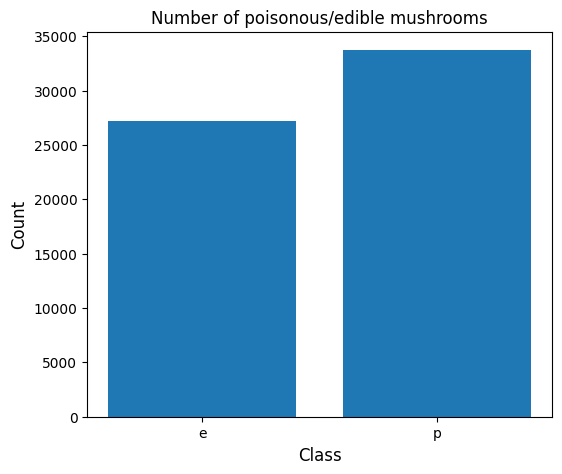

In [ ]:
# Plotting the value counts
rows = class_counts_df.collect()
labels = [r["class"] for r in rows]
values = [r["count"] for r in rows]

plt.figure(figsize=(6, 5))
plt.bar(labels, values)
plt.ylabel("Count", fontsize=12)
plt.xlabel("Class", fontsize=12)
plt.title("Number of poisonous/edible mushrooms")
plt.show()

## 5. Visualizing the Data

### 5.1. Preparing the Data for Visualization

In this step, I create a separate Spark DataFrame for visualization and add a numeric target column `label` by mapping the original classes (e → 0, p → 1) while keeping `class` for readability. We then split the predictors into the three continuous numeric features (cap-diameter, stem-height, stem-width) and the remaining categorical features.

To make the data suitable for plots, missing values in categorical columns are filled with an explicit `"missing"` category, and categorical variables are temporarily converted to numeric indices using `StringIndexer` (for visualization only). Finally, the numeric columns are assembled into a vector and standardized with `StandardScaler`, producing a scaled numeric vector (`num_scaled`) that makes distributions comparable across plots.


In [ ]:
df_plot = df_no_dups

# target: map {"e": 0, "p": 1}
df_plot = df_plot.withColumn(
    "label",
    F.when(F.col("class") == "e", F.lit(0.0))
     .when(F.col("class") == "p", F.lit(1.0))
     .otherwise(F.lit(None).cast("double"))
)

# features
X_cols = [c for c in df_plot.columns if c not in ["class", "label"]]
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cat_cols = [c for c in X_cols if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", cat_cols)

Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-root', 'stem-surface', 'stem-color', 'veil-type', 'veil-color', 'has-ring', 'ring-type', 'spore-print-color', 'habitat', 'season']


In [ ]:
# Fill nulls in categoricals to make "missing" explicit
df_enc = df_plot.na.fill({c: "missing" for c in cat_cols})

# "Ordinal encode" categoricals (Spark equivalent: StringIndexer -> index values)
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep")
    for c in cat_cols
]

# Scale numeric columns (Spark StandardScaler works on a vector column)
num_assembler = VectorAssembler(inputCols=num_cols, outputCol="num_vec")
scaler = StandardScaler(inputCol="num_vec", outputCol="num_scaled", withMean=True, withStd=True)

# Build and run pipeline
pipe = Pipeline(stages=indexers + [num_assembler, scaler])
df_enc = pipe.fit(df_enc).transform(df_enc)

# Show a quick preview (similar to df_enc.head())
df_enc.select(["class", "label"] + [f"{c}_idx" for c in cat_cols] + ["num_scaled"]).show(5, truncate=False)

+-----+-----+-------------+---------------+-------------+------------------------+-------------------+----------------+--------------+-------------+----------------+--------------+-------------+--------------+------------+-------------+---------------------+-----------+----------+-----------------------------------------------------------+
|class|label|cap-shape_idx|cap-surface_idx|cap-color_idx|does-bruise-or-bleed_idx|gill-attachment_idx|gill-spacing_idx|gill-color_idx|stem-root_idx|stem-surface_idx|stem-color_idx|veil-type_idx|veil-color_idx|has-ring_idx|ring-type_idx|spore-print-color_idx|habitat_idx|season_idx|num_scaled                                                 |
+-----+-----+-------------+---------------+-------------+------------------------+-------------------+----------------+--------------+-------------+----------------+--------------+-------------+--------------+------------+-------------+---------------------+-----------+----------+-----------------------------------

### 5.2. Box Plot (Numeric Features vs. Class)

In this section, I use box plots to compare how the three continuous numeric features vary between edible (e) and poisonous (p) mushrooms. Because Spark DataFrames are not plotted directly with matplotlib/seaborn, I first select only the required columns, drop rows with missing numeric values, and then take a random sample (with an upper limit) to keep plotting fast in Colab. The resulting sample is converted to a small pandas DataFrame purely for visualization. Box plots are shown only for **cap-diameter**, **stem-height**, and **stem-width**, since all other variables in this dataset are categorical.


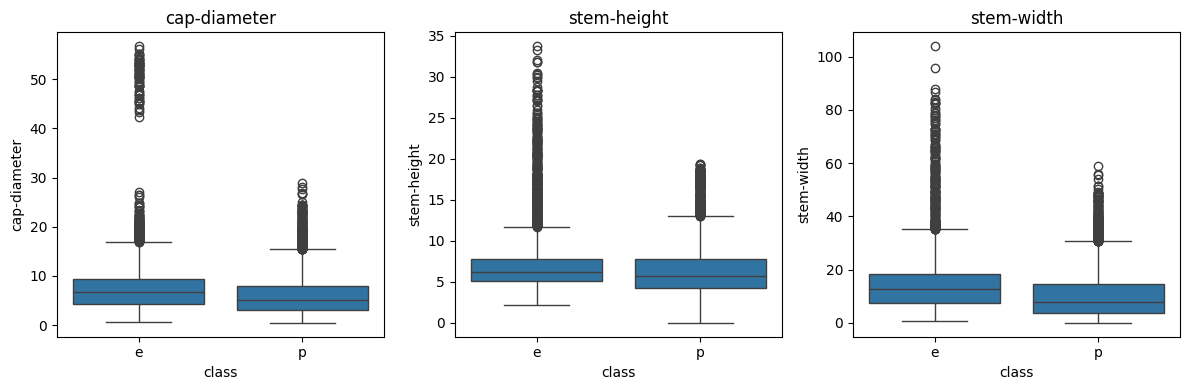

In [ ]:
num_cols = ["cap-diameter", "stem-height", "stem-width"]

# Take a manageable sample to plot (adjust fraction/limit as you like)
plot_sdf = df_no_dups.select(["class"] + num_cols).dropna(subset=num_cols)

# Option A (recommended): random sample + hard cap
plot_pdf = (plot_sdf
            .sample(withReplacement=False, fraction=0.2, seed=42)  # sample 20%
            .limit(20000)                                         # cap rows for speed
            .toPandas())

# Plotting
plt.figure(figsize=(12, 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=plot_pdf, x="class", y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

**!Conclusion**:
Edible mushrooms show slightly higher median size (cap diameter, stem height, stem width), but the distributions overlap heavily, so these numeric features alone don’t separate the classes well. All three variables also contain many outliers, indicating high variation in size.

#### 5.3. Correlation Heatmap (Label vs. Numeric Features)

In this step, we compute a correlation heatmap to quickly examine linear relationships between the target label and the three continuous numeric variables (cap-diameter, stem-height, stem-width). The correlation matrix is calculated directly in Spark using `VectorAssembler` and `Correlation.corr`, then visualized as a heatmap (absolute values scaled to 0–1) for easier interpretation. Since most dataset attributes are categorical, the correlation analysis is limited to these numeric features.


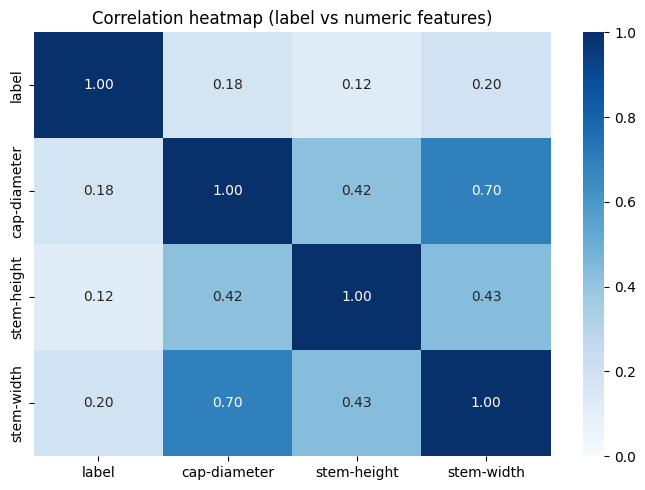

In [ ]:
# Build the list of columns to include in the correlation matrix
num_cols = ["cap-diameter", "stem-height", "stem-width"]
cols_for_corr = ["label"] + num_cols

df_corr = df_plot.select(cols_for_corr).dropna()

vec = VectorAssembler(inputCols=cols_for_corr, outputCol="features").transform(df_corr).select("features")
corr_np = Correlation.corr(vec, "features").head()[0].toArray()

# Plot (abs scaled 0..1 like your original)
plt.figure(figsize=(7, 5))
sns.heatmap(
    np.abs(corr_np),
    cmap="Blues",
    vmin=0, vmax=1,
    annot=True, fmt=".2f",
    xticklabels=cols_for_corr,
    yticklabels=cols_for_corr
)
plt.title("Correlation heatmap (label vs numeric features)")
plt.tight_layout()
plt.show()


**!Conclusion:**
The label has only weak linear correlations with each numeric feature (about 0.12–0.20), so none of the size measurements alone explains edibility well. In contrast, the numeric features are more strongly related to each other—especially cap-diameter vs. stem-width (~0.70)—suggesting some redundancy among size variables. Overall, this supports the idea that accurate classification likely depends on combining multiple attributes (especially the categorical ones), rather than relying on a single numeric measurement.

#### 5.4. Categorical Association Heatmap (Cramér’s V)

Since most attributes in this dataset are categorical, Pearson correlation is not appropriate. Instead, we use **Cramér’s V**, a chi-square–based measure of association between two categorical variables that ranges from **0** (no association) to **1** (strong association). Here, we compute Cramér’s V between each selected categorical feature and the target label to identify which attributes are most related to mushroom edibility.

To avoid dropping records during the contingency-table computation, we replace `?` and null values with an explicit `"missing"` category for this analysis. We focus on **feature vs. label** (rather than all pairwise feature–feature associations) because a full Cramér’s V matrix requires computing contingency tables for every feature pair, which is significantly more expensive and can become hard to read; for modeling, the most informative first step is understanding which features are directly associated with the target.


In [ ]:
def cramers_v(df, col_x: str, col_y: str, fill_value: str = "missing") -> float:
    """
    Bias-corrected Cramér's V (0..1) for two categorical columns in a Spark DataFrame.

    Parameters
    ----------
    df : pyspark.sql.DataFrame
        Input Spark DataFrame.
    col_x, col_y : str
        Names of the categorical columns.
    fill_value : str
        Value used to fill nulls in the two columns before computing the table.

    Returns
    -------
    float
        Bias-corrected Cramér's V in [0, 1].
    """

    # Fill nulls (like pandas fillna("missing"))
    sdf = df.select(col_x, col_y).na.fill({col_x: fill_value, col_y: fill_value})

    # Build contingency table in Spark: rows = col_x, columns = col_y
    #    This produces columns: [col_x, <y_cat1>, <y_cat2>, ...]
    ct = (
        sdf.groupBy(col_x, col_y)
           .count()
           .groupBy(col_x)
           .pivot(col_y)
           .sum("count")
           .na.fill(0)
    )

    # Collect the contingency table to driver (small aggregated table)
    pdf = ct.toPandas()
    if pdf.shape[0] == 0:
        return 0.0

    # Keep only the y-category count columns (exclude the row key col_x)
    y_cols = [c for c in pdf.columns if c != col_x]
    counts = pdf[y_cols].to_numpy(dtype=float)

    n = counts.sum()
    if n <= 1:
        return 0.0

    # Compute chi-square from counts (no SciPy needed)
    row_sums = counts.sum(axis=1, keepdims=True)
    col_sums = counts.sum(axis=0, keepdims=True)
    expected = row_sums @ col_sums / n

    mask = expected > 0
    chi2 = ((counts - expected) ** 2 / expected)[mask].sum()

    # Bias-corrected Cramér’s V (same formula as your pandas version)
    r, k = counts.shape
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
    rcorr = r - ((r - 1) ** 2) / (n - 1)
    kcorr = k - ((k - 1) ** 2) / (n - 1)

    denom = min(kcorr - 1, rcorr - 1)
    return float(np.sqrt(phi2corr / denom)) if denom > 0 else 0.0


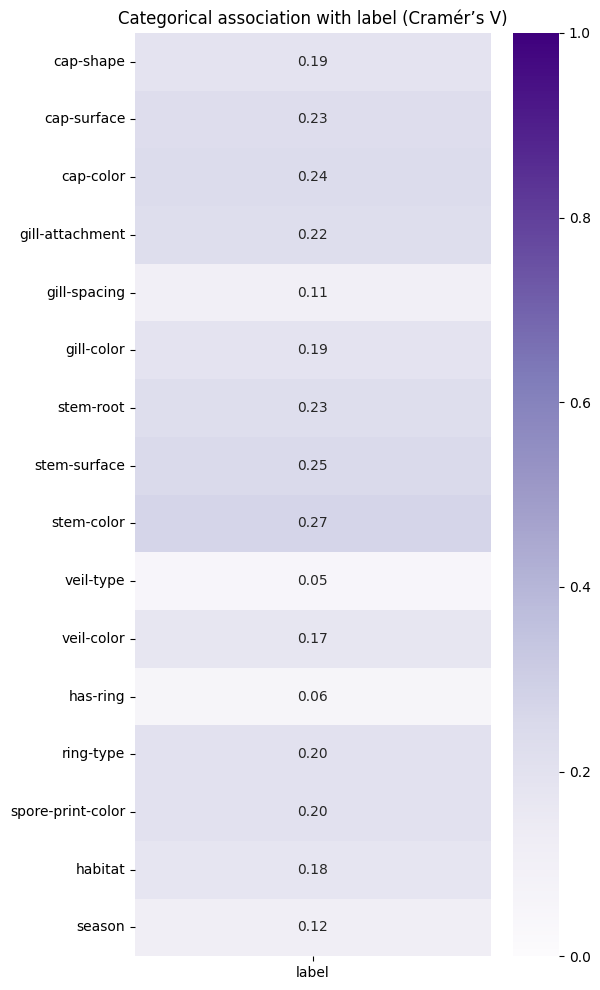

In [ ]:
# Choose the subset of categorical columns (same as your list) ---
subset = ["cap-shape", "cap-surface", "cap-color",
          "gill-attachment", "gill-spacing", "gill-color",
          "stem-root", "stem-surface", "stem-color",
          "veil-type", "veil-color",
          "has-ring", "ring-type",
          "spore-print-color", "habitat", "season"]

# Keep only columns that actually exist in your Spark DF
subset = [c for c in subset if c in df_no_dups.columns]

# Prepare Spark DF: select subset + label, replace "?" with null, fill nulls with "missing" ---
df_cat = df_plot.select(subset + ["label"])

# Replace "?" with null on categoricals (Spark equivalent of df.replace("?", np.nan))
for c in subset:
    df_cat = df_cat.withColumn(c, F.when(F.col(c) == "?", F.lit(None)).otherwise(F.col(c)))

# Fill missing categoricals with "missing"
df_cat = df_cat.na.fill({c: "missing" for c in subset})

# Treat label as categorical for Cramér's V (0/1 -> "0"/"1")
df_cat = df_cat.withColumn("label_cat", F.col("label").cast("string"))

# Compute Cramér’s V: each feature vs label ---
results = []
for c in subset:
    v = cramers_v(df_cat, c, "label_cat")
    results.append((c, v))

# Plot without pandas: build a (n_features x 1) matrix ---
features = [r[0] for r in results]
vals = np.array([r[1] for r in results], dtype=float).reshape(-1, 1)

plt.figure(figsize=(6, 10))
sns.heatmap(vals, annot=True, fmt=".2f", cmap="Purples", vmin=0, vmax=1,
            yticklabels=features, xticklabels=["label"])
plt.title("Categorical association with label (Cramér’s V)")
plt.tight_layout()
plt.show()


**!Conclusion:**
The Cramér’s V analysis shows that individual categorical attributes have weak to moderate associations with the target label (roughly 0.05–0.27), indicating that no single categorical feature is sufficient to explain edibility on its own. Among the evaluated variables, stem-color (≈0.27), stem-surface (≈0.25), cap-color (≈0.24), and stem-root / cap-surface (≈0.23) exhibit the strongest relationships with the label, making them promising predictors. In contrast, veil-type (≈0.05) and has-ring (≈0.06) show very weak association and are likely less informative in isolation. Overall, these results suggest that accurate classification will rely on combining multiple categorical cues, rather than depending on any single attribute.

## 6. Data Preprocessing and Train/Test Split

In this section, I prepare the dataset for Spark ML modeling. First, I create a numeric target column `label` by mapping the original classes (e → 0, p → 1). I then identify the three continuous numeric features (cap-diameter, stem-height, stem-width) and treat all remaining columns as categorical. To standardize missing-value handling, I convert `"?"` entries in categorical columns to null and fill missing categories with an explicit `"missing"` value.

Next, I split the data into training and test sets using Spark’s `randomSplit` (80/20). Finally, I build a preprocessing pipeline that produces a single feature vector required by Spark ML: numeric columns are imputed with the median, categorical columns are indexed (`StringIndexer`) and one-hot encoded (`OneHotEncoder`), and all processed features are combined into a `features` vector using `VectorAssembler`. The pipeline is fit on the training set only and then applied to both splits to create model-ready DataFrames (`train_ready`, `test_ready`).


In [6]:
# Define numeric & categorical columns
num_cols = ["cap-diameter", "stem-height", "stem-width"]
all_cols = df_no_dups.columns

# Features = all except target columns
feature_cols = [c for c in all_cols if c != "class"]

cat_cols = [c for c in feature_cols if c not in num_cols]

print("Numeric:", num_cols)
print("Categorical:", len(cat_cols))

Numeric: ['cap-diameter', 'stem-height', 'stem-width']
Categorical: 17


In [7]:
# Create label + clean categoricals ("?" -> null, then fill)
df_prep = df_no_dups

# label: e->0, p->1
df_prep = df_prep.withColumn(
    "label",
    F.when(F.col("class") == "e", F.lit(0.0))
     .when(F.col("class") == "p", F.lit(1.0))
     .otherwise(F.lit(None).cast("double"))
)

# Replace "?" with null in categorical columns
for c in cat_cols:
    df_prep = df_prep.withColumn(c, F.when(F.col(c) == "?", F.lit(None)).otherwise(F.col(c)))

# Fill missing categoricals with "missing"
df_prep = df_prep.na.fill({c: "missing" for c in cat_cols})

# (Optional) drop rows where label is null
df_prep = df_prep.dropna(subset=["label"])

print("Rows after cleaning:", df_prep.count())
print("Columns:", len(df_prep.columns))

Rows after cleaning: 60923
Columns: 22


In [8]:
# Train/Test split
# Spark doesn't do stratified split out of the box; randomSplit is standard in Spark projects.
train_df, test_df = df_prep.randomSplit([0.8, 0.2], seed=42)

print("Train rows:", train_df.count())
print("Test rows:", test_df.count())

Train rows: 48927
Test rows: 11996


In [9]:
# Preprocessing pipeline (linear-model friendly)

# Numeric: median imputation
imputer = Imputer(
    inputCols=num_cols,
    outputCols=[f"{c}_imp" for c in num_cols]
).setStrategy("median")
num_imp_cols = [f"{c}_imp" for c in num_cols]

# Scale numeric: assemble -> scale
num_vec = VectorAssembler(inputCols=num_imp_cols, outputCol="num_vec")
scaler = StandardScaler(inputCol="num_vec", outputCol="num_scaled", withMean=True, withStd=True)

# Categorical: StringIndexer -> OneHotEncoder
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
idx_cols = [f"{c}_idx" for c in cat_cols]

encoder = OneHotEncoder(
    inputCols=idx_cols,
    outputCols=[f"{c}_ohe" for c in cat_cols],
    handleInvalid="keep"
)
ohe_cols = [f"{c}_ohe" for c in cat_cols]

# Final features: scaled numeric + one-hot categoricals
assembler = VectorAssembler(inputCols=["num_scaled"] + ohe_cols, outputCol="features")

# Full preprocessing pipeline
prep_pipeline = Pipeline(stages=[imputer, num_vec, scaler] + indexers + [encoder, assembler])


In [10]:
# Fit on train only, then transform train & test
prep_model = prep_pipeline.fit(train_df)
train_ready = prep_model.transform(train_df).select("label", "features")
test_ready  = prep_model.transform(test_df).select("label", "features")

n_features = train_ready.first()["features"].size
print("Train ready rows:", train_ready.count())
print("Test ready rows:", test_ready.count())
print("Number of assembled features:", n_features)

Train ready rows: 48927
Test ready rows: 11996
Number of assembled features: 145


## Helper Functions

## 7. Helper Functions

To keep the notebook clean and avoid repeating code across models, I define a set of reusable helper functions used throughout the training and evaluation steps.

- `base_feature_name()` maps engineered pipeline column names (e.g., imputed or one-hot encoded columns) back to their original feature names so results can be interpreted at the feature level.

- `linear_feature_importance()` extracts feature importances from a fitted Spark tree model (Decision Tree / Random Forest / Gradient-Boosted Trees), then aggregates one-hot encoded dimensions back to the original categorical feature and reports the results both as a table and a horizontal bar plot.

- `plot_confusion_matrix()` computes the confusion matrix directly from Spark predictions, prints key classification metrics (accuracy, F1-score, precision, recall), and visualizes the confusion matrix as a heatmap for an intuitive overview of prediction errors.

- `nb_feature_discriminativeness()` provides an interpretable “importance-like” summary for **Naive Bayes**. Since Naive Bayes does not produce feature importances or coefficients like tree/linear models, this function uses the learned log-conditional probabilities (`theta`) and computes how strongly each feature differs between the two classes (based on \|Δ log P(x|class)\|). The scores are aggregated back to the original feature names (grouping one-hot encoded dimensions) and displayed as both a table and a bar plot.

- `print_all_models_table()` prints a compact, formatted comparison table for all trained models (e.g., LR, Linear SVM, Naive Bayes), reporting key test metrics such as **accuracy** and **F1-score** in a consistent layout for the final results section.

In [11]:
# Map pipeline column name back to original feature name
def base_feature_name(col_name: str) -> str:
  if col_name.endswith("_imp"):
      return col_name[:-4]  # remove "_imp"
  if col_name.endswith("_ohe"):
      return col_name[:-4]  # remove "_ohe"
  if col_name.endswith("_idx"):
      return col_name[:-4]  # remove "_idx" (if ever assembled directly)
  return col_name


In [12]:
def linear_feature_importance(
    fitted_pipeline_model,
    features_col: str = "features",
    top_m: int = 20,
    plot: bool = True,
    title: str = "Linear Model Feature Importance (|coef|)",
    print_table: bool = True
):
    """
    Works for LogisticRegressionModel and LinearSVCModel (last stage has .coefficients).
    Aggregates absolute coefficients back to original feature names (sums OHE blocks).
    Returns sorted list of (feature_name, importance_percent).
    """
    stages = fitted_pipeline_model.stages
    if not stages:
        raise ValueError("PipelineModel has no stages.")

    model_stage = stages[-1]
    if not hasattr(model_stage, "coefficients"):
        raise ValueError("Last stage does not have .coefficients (not LR/LinearSVC?).")

    coefs = np.array(model_stage.coefficients)  # length = num features in vector
    abs_coefs = np.abs(coefs)

    # find assembler(features)
    assembler_model = None
    for s in stages:
        if isinstance(s, VectorAssembler) and s.getOutputCol() == features_col:
            assembler_model = s
            break
    if assembler_model is None:
        raise ValueError(f"Could not find VectorAssembler with outputCol='{features_col}'.")

    assembler_inputs = assembler_model.getInputCols()

    # find fitted OneHotEncoderModel (to know vector block sizes)
    encoder_model = None
    for s in stages:
        if isinstance(s, OneHotEncoderModel):
            encoder_model = s
            break

    ohe_size_map = {}
    if encoder_model is not None:
        ohe_out_cols = list(encoder_model.getOutputCols())
        ohe_sizes = list(encoder_model.categorySizes)
        ohe_size_map = dict(zip(ohe_out_cols, map(int, ohe_sizes)))

    # aggregate abs coefficients by base feature
    agg = {}
    idx = 0

    for col in assembler_inputs:
        base = base_feature_name(col)

        # numeric vector (e.g., "num_scaled") is itself a vector -> size = len(num_cols)
        # if you assembled "num_scaled" as one input, its size is the number of numeric features
        if col == "num_scaled":
            size = len(num_cols)

        # OHE vectors
        elif col in ohe_size_map:
            size = ohe_size_map[col]

        # fallback scalar
        else:
            size = 1

        block_sum = float(abs_coefs[idx: idx + size].sum()) if size > 0 else 0.0
        agg[base] = agg.get(base, 0.0) + block_sum
        idx += size

    total = sum(agg.values()) if agg else 0.0
    items = [(k, (v / total * 100.0) if total > 0 else 0.0) for k, v in agg.items()]
    items.sort(key=lambda x: x[1], reverse=True)

    # table
    if print_table:
        top = items[:top_m]
        name_w = max(len("Feature"), max((len(f) for f, _ in top), default=0))
        print(f"\n{title}")
        print(f"{'Feature':<{name_w}}  {'Importance (%)':>14}")
        print("-" * (name_w + 2 + 14))
        for feat, pct in top:
            print(f"{feat:<{name_w}}  {pct:>14.2f}")

    # plotting
    if plot:
        top = items[:top_m]
        feats = [f for f, _ in top][::-1]
        vals  = [v for _, v in top][::-1]

        plt.figure(figsize=(8, 5))
        plt.barh(feats, vals)
        plt.title(title)
        plt.xlabel("importance (%)")
        plt.tight_layout()
        plt.show()

    return items

In [ ]:
def plot_confusion_matrix(
    pred_df,
    title="Confusion Matrix",
    label_col="label",
    pred_col="prediction",
    class_names=("edible", "poisonous"),
    positive_label=1.0,
    show_metrics=True
):
    # Keep only needed cols and cast to double for consistency
    df = pred_df.select(
        F.col(label_col).cast("double").alias("label"),
        F.col(pred_col).cast("double").alias("prediction")
    )

    #  Compute confusion counts robustly (no pivot / no key mismatch)
    tp = df.filter((F.col("label") == positive_label) & (F.col("prediction") == positive_label)).count()
    tn = df.filter((F.col("label") != positive_label) & (F.col("prediction") != positive_label)).count()
    fp = df.filter((F.col("label") != positive_label) & (F.col("prediction") == positive_label)).count()
    fn = df.filter((F.col("label") == positive_label) & (F.col("prediction") != positive_label)).count()

    cm = np.array([[tn, fp],
                   [fn, tp]], dtype=int)

    # Metrics
    if show_metrics:
        acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

        acc = acc_eval.evaluate(df)
        f1  = f1_eval.evaluate(df)

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall    = tp / (tp + fn) if (tp + fn) > 0 else 0.0

        print(f"Accuracy : {acc*100:.3f}%")
        print(f"F1-score  : {f1:.5f}")
        print(f"Precision : {precision:.5f}")
        print(f"Recall    : {recall:.5f}\n")

    #  Plotting
    plt.figure(figsize=(5, 4))
    sns.heatmap(
        cm, annot=True, fmt="d", cmap="Blues",
        xticklabels=list(class_names),
        yticklabels=list(class_names)
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return cm


In [13]:
def nb_feature_discriminativeness(
    fitted_pipeline_model,
    features_col="features",
    top_m=20,
    plot=True,
    title="Naive Bayes: Most Discriminative Features (|Δ log P(x|class)|)",
    print_table=True
):
    stages = fitted_pipeline_model.stages
    nb_stage = stages[-1]
    if not isinstance(nb_stage, NaiveBayesModel):
        raise ValueError("Last stage is not a NaiveBayesModel.")

    # theta shape: [numClasses x numFeatures]
    theta = nb_stage.theta.toArray()
    if theta.shape[0] != 2:
        raise ValueError("This helper is for binary classification (2 classes).")

    # discriminative score per feature dimension
    delta = theta[1, :] - theta[0, :]
    score = np.abs(delta)

    # find assembler(features)
    assembler_model = None
    for s in stages:
        if isinstance(s, VectorAssembler) and s.getOutputCol() == features_col:
            assembler_model = s
            break
    if assembler_model is None:
        raise ValueError(f"Could not find VectorAssembler with outputCol='{features_col}'.")

    assembler_inputs = assembler_model.getInputCols()

    # find OHE model (optional)
    encoder_model = None
    for s in stages:
        if isinstance(s, OneHotEncoderModel):
            encoder_model = s
            break

    ohe_size_map = {}
    if encoder_model is not None:
        ohe_out_cols = list(encoder_model.getOutputCols())
        ohe_sizes = list(encoder_model.categorySizes)
        ohe_size_map = dict(zip(ohe_out_cols, map(int, ohe_sizes)))

    # aggregate by original feature (sum of scores in each block)
    agg = {}
    idx = 0
    for col in assembler_inputs:
        base = base_feature_name(col)

        # In NB pipeline we recommended numeric imputed scalars (cap-diameter_imp etc.)
        if col.endswith("_imp"):
            size = 1
        elif col in ohe_size_map:
            size = ohe_size_map[col]
        else:
            size = 1

        block_sum = float(score[idx:idx+size].sum()) if size > 0 else 0.0
        agg[base] = agg.get(base, 0.0) + block_sum
        idx += size

    total = sum(agg.values()) if agg else 0.0
    items = [(k, (v/total*100.0) if total > 0 else 0.0) for k, v in agg.items()]
    items.sort(key=lambda x: x[1], reverse=True)

    if print_table:
        top = items[:top_m]
        name_w = max(len("Feature"), max((len(f) for f, _ in top), default=0))
        print(f"\n{title}")
        print(f"{'Feature':<{name_w}}  {'Score (%)':>10}")
        print("-" * (name_w + 2 + 10))
        for feat, pct in top:
            print(f"{feat:<{name_w}}  {pct:>10.2f}")

    if plot:
        top = items[:top_m]
        feats = [f for f, _ in top][::-1]
        vals  = [v for _, v in top][::-1]

        plt.figure(figsize=(8, 5))
        plt.barh(feats, vals)
        plt.title(title)
        plt.xlabel("discriminativeness (%)")
        plt.tight_layout()
        plt.show()

    return items

In [14]:
def print_all_models_table(all_models):
    model_w = max(len(r["model"]) for r in all_models + [{"model":"Model"}])
    acc_w = len("Test Accuracy (%)")
    f1_w = len("Test F1")

    header = f"{'Model':<{model_w}}  {'Test Accuracy (%)':>{acc_w}}  {'Test F1':>{f1_w}}"
    print(header)
    print("-" * len(header))

    for r in all_models:
        print(f"{r['model']:<{model_w}}  {r['test_acc']:>{acc_w}.3f}  {r['test_f1']:>{f1_w}.5f}")

## 8. Classification Methods

## 8. Classification Methods

In this section, we train and compare three classifiers—**Binomial Logistic Regression (LR)**, **Linear Support Vector Machine (Linear SVM)**, and **Naive Bayes (NB)**—to predict whether a mushroom is edible or poisonous. All models are trained and evaluated using the same preprocessing pipeline and the same train/test split to ensure a fair comparison. We report standard classification metrics (accuracy, precision, recall, and F1-score) and summarize the results to identify which approach performs best on this dataset.


In [43]:
# Store model results for later comparison
all_models = []

### 8.1. Logistic Regression

#### 8.1.1. Train LR Pipeline

I attempted to tune Logistic Regression by building a Spark ML ParamGrid over two key hyperparameters—`regParam` (regularization strength) and `elasticNetParam` (L1/L2 mixing)—and running a 3-fold CrossValidator using AUC as the evaluation metric. However, this grid search was computationally expensive in Colab and did not finish within a reasonable time (it ran for about an hour without producing final results). Therefore, instead of full cross-validation, I proceeded with a manual hyperparameter search, adjusting these values and evaluating performance directly on the held-out test set to select a suitable configuration.

In [ ]:
# lr = LogisticRegression(labelCol="label", featuresCol="features", family="binomial", maxIter=300)

# lr_pipe = Pipeline(stages=prep_pipeline.getStages() + [lr])

# paramGrid = (ParamGridBuilder()
#     .addGrid(lr.regParam, [0.0, 0.001, 0.01, 0.1, 0.5])
#     .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
#     .build()
# )

# auc_eval = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")

# cv = CrossValidator(
#     estimator=lr_pipe,
#     estimatorParamMaps=paramGrid,
#     evaluator=auc_eval,
#     numFolds=3,
#     parallelism=2,
#     seed=42
# )

# cv_model = cv.fit(train_df)
# lr_best = cv_model.bestModel

# best_lr = lr_best.stages[-1]
# print("Best regParam:", best_lr.getRegParam())
# print("Best elasticNetParam:", best_lr.getElasticNetParam())

In [15]:
lr = LogisticRegression(
    labelCol="label",
    featuresCol="features",
    family="binomial",
    maxIter=300,
    regParam= 0.001,
    elasticNetParam= 1.0
)

lr_model = Pipeline(stages=prep_pipeline.getStages() + [lr])
lr_fitted = lr_model.fit(train_df)

#### 8.1.2. Coefficient Weights

After training the Logistic Regression model, I inspect the learned **coefficient weights** to understand which inputs most influence the decision boundary. Since the pipeline applies one-hot encoding, each categorical feature expands into multiple dimensions; therefore, I aggregate the absolute coefficient values back to the original feature level and normalize them to percentages for easier interpretation. Finally, I report and plot the top 20 features with the largest normalized absolute weights.



Logistic Regression: Normalized Absolute Coefficient Weights (%)
Feature               Importance (%)
------------------------------------
ring-type                      12.66
veil-color                     12.23
stem-color                     11.42
stem-surface                   10.62
stem-root                      10.22
spore-print-color               8.64
cap-surface                     5.87
veil-type                       5.55
gill-attachment                 5.39
cap-color                       4.92
habitat                         4.46
gill-color                      2.70
cap-shape                       1.97
season                          1.28
gill-spacing                    0.88
has-ring                        0.53
does-bruise-or-bleed            0.43
num_scaled                      0.25


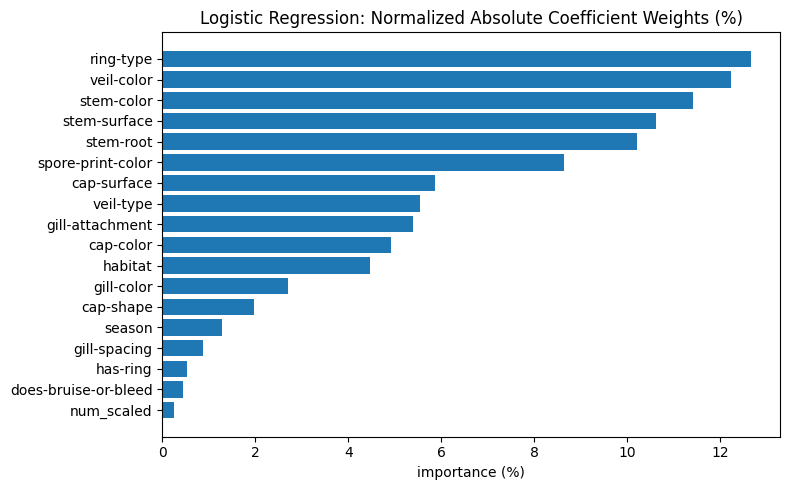

In [ ]:
# Feature importance (|coeff|)
lr_items = linear_feature_importance(lr_fitted, top_m=20, plot=True, title="Logistic Regression: Normalized Absolute Coefficient Weights (%)")

**!Conclusion:**
Logistic Regression places most weight on a small set of categorical attributes, with** ring-type**, **veil-color**, **stem-color**, and **stem-surface/root** having the strongest influence on the decision boundary. Overall, categorical features dominate the model, while the scaled numeric measurements contribute relatively little in comparison.

#### 8.1.3. Predicting on the Test Set

After fitting the Logistic Regression pipeline, I generate predictions on the held-out test set using `transform()`. I evaluate the model using Spark’s built-in evaluators to report **test accuracy** and **F1-score**. Finally, I compute the **training accuracy** on the training split as a simple generalization check by comparing it with the test performance.


In [16]:
# Predict
lr_pred = lr_fitted.transform(test_df)

# Accuracy/F1 (Spark)
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

acc_lr = acc_eval.evaluate(lr_pred)
f1_lr  = f1_eval.evaluate(lr_pred)

print(f"Test Accuracy : {acc_lr*100:.3f}%")
print(f"Test F1-score  : {f1_lr:.5f}")

Test Accuracy : 86.696%
Test F1-score  : 0.86709


In [ ]:
# Train accuracy
lr_pred_train = lr_fitted.transform(train_df)
acc_lr_train = acc_eval.evaluate(lr_pred_train)
print(f"Train accuracy: {acc_lr_train*100:.3f}%")


Train accuracy: 86.660%


**!Conclusion:**
The Logistic Regression model achieves moderate performance (≈86.70% test accuracy, F1 ≈0.867). The training and test accuracies are nearly the same, indicating consistent generalization with no clear overfitting, but also indicating that a linear decision boundary is not sufficient to reach the near-perfect performance observed with tree-based models.

#### 8.1.4. Confusion Matrix

To complement the evaluation metrics, I plot the **confusion matrix** for Logistic Regression predictions. This visualization shows how many edible and poisonous mushrooms are classified correctly and highlights the types of errors (false positives vs. false negatives). It provides a clearer view of model behavior beyond overall accuracy.


Accuracy : 86.696%
F1-score  : 0.86709
Precision : 0.88707
Recall    : 0.87136



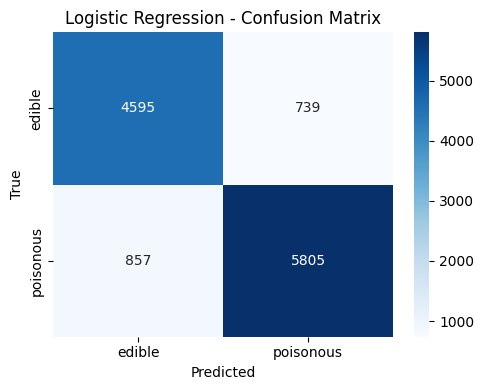

In [ ]:
# Confusion matrix + (your function prints precision/recall too)
lr_cm = plot_confusion_matrix(lr_pred, title="Logistic Regression - Confusion Matrix")

**!Conclusion:**
The confusion matrix shows that Logistic Regression makes a noticeable number of errors in both directions, with slightly more poisonous mushrooms misclassified as edible than the reverse. Overall, the model provides reasonable but not highly accurate separation between the two classes compared to the tree-based approaches.

#### 8.1.5. ROC Curve

This cell builds the ROC curve for the Logistic Regression by collecting the model’s predicted probability for the positive class (p = 1) and the true labels, then sweeping decision thresholds to compute TPR vs. FPR and the AUC summary score.

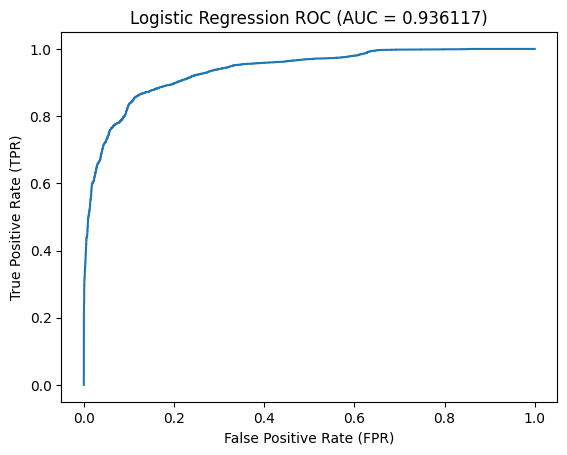

In [41]:
from sklearn.metrics import roc_curve, auc

scores_labels = (
    lr_pred.select("probability", "label")
          .rdd
          .map(lambda r: (float(r["probability"][1]), float(r["label"])))
          .collect()
)

y_score = [s for s, y in scores_labels]
y_true  = [y for s, y in scores_labels]

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1.0)
roc_auc_lr = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"Logistic Regression ROC (AUC = {roc_auc_lr:.6f})")
plt.show()

**!CONCLUSION:**

The Logistic Regression ROC curve stays well above the random baseline and achieves an AUC ≈ 0.936, which indicates strong discrimination between poisonous (p=1) and edible (e=0) mushrooms. However, compared to the tree-based models (DT/RF/GBT), the curve is less concentrated near the top-left corner, meaning Logistic Regression generally needs a higher false positive rate to reach very high true positive rates, so its overall separation power is good but not near-perfect.

In [47]:
# Adding the KNN Results to the all_models list
lr_results = {"model": "Logistic Regression", "test_acc": round(acc_lr * 100, 3), "test_f1": round(f1_lr, 5), "roc_auc": round(float(roc_auc_lr),3)}
all_models.append(lr_results)

In [50]:
all_models

[{'model': 'Logistic Regression',
  'test_acc': 86.696,
  'test_f1': 0.86709,
  'roc_auc': 0.936}]

### 8.2. Linear Support Vector Machine Classifier (SVM or Spark LinearSVC)

#### 8.2.1. Training the Linear SVM Pipeline

In this step, I train a **Linear Support Vector Machine (LinearSVC)** using the same preprocessing pipeline to ensure consistent feature handling. Linear SVM learns a linear decision boundary by maximizing the margin between the two classes, while the regularization parameter (`regParam`) controls model complexity. I fit the full pipeline on the training split so that preprocessing and model training are applied as a single, reproducible workflow.


In [20]:
#  Define Linear SVC
svc = LinearSVC(
    labelCol="label",
    featuresCol="features",
    maxIter=500,
    regParam=0.0001
)

# Full pipeline: preprocessing + model
svc_model = Pipeline(stages=prep_pipeline.getStages() + [svc])

# Fit on training DataFrame
svc_fitted = svc_model.fit(train_df)


#### 8.2.2. Coefficient Weights (Linear SVM)

After training the Linear SVM model, I inspect the learned **weight vector** to understand which inputs most influence the decision boundary. Because categorical variables are one-hot encoded into multiple dimensions, I aggregate the absolute weights back to the original feature level and normalize them to percentages for easier interpretation. Finally, I report and plot the top 20 features with the largest normalized absolute weights.



Linear SVM: Normalized Absolute Feature Weights (%)
Feature               Importance (%)
------------------------------------
veil-color                     13.50
ring-type                      13.40
stem-color                     12.89
spore-print-color               9.70
stem-surface                    8.77
stem-root                       7.42
veil-type                       6.34
gill-attachment                 5.65
cap-color                       5.35
cap-surface                     5.00
habitat                         3.39
gill-color                      2.80
cap-shape                       2.41
gill-spacing                    1.12
season                          0.79
has-ring                        0.62
does-bruise-or-bleed            0.54
num_scaled                      0.30


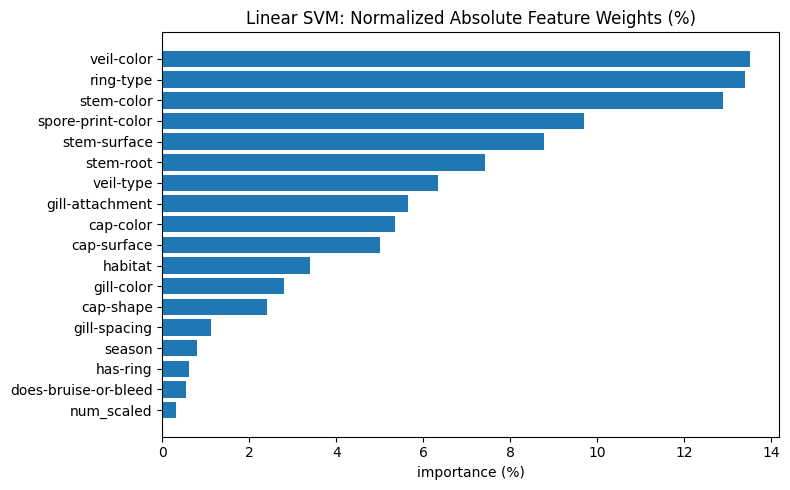

In [ ]:
#  coefficient weights
svc_items = linear_feature_importance(svc_fitted, top_m=20, plot=True, title="Linear SVM: Normalized Absolute Feature Weights (%)")

**!Conclusion:**
The Linear SVM relies mainly on a few categorical attributes, with **veil-color**, **ring-type**, and **stem-color** having the largest weight contributions, followed by **spore-print-color** and **stem-surface/root**. The scaled numeric size features contribute very little, suggesting that the model’s decisions are driven primarily by categorical characteristics.

#### 8.2.3. Predicting on the Test Set

After fitting the Linear SVM pipeline, I generate predictions on the held-out test set using `transform()`. I then evaluate performance with Spark’s built-in evaluators, reporting **test accuracy** and **F1-score**. For transparency, I also print the main training settings (`regParam` and `maxIter`). Finally, I compute the **training accuracy** on the training split as a simple generalization check by comparing it with the test performance.


In [21]:
# Predict on held-out test set
svc_pred = svc_fitted.transform(test_df)

# Metrics (accuracy + F1)
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

acc_svc = acc_eval.evaluate(svc_pred)
f1_svc  = f1_eval.evaluate(svc_pred)

svc_stage = svc_fitted.stages[-1]
print(f"regParam: {svc_stage.getRegParam()}")
print(f"maxIter: {svc_stage.getMaxIter()}")

print(f"Test Accuracy : {acc_svc * 100:.3f}%")
print(f"Test F1-score  : {f1_svc:.5f}")

regParam: 0.0001
maxIter: 500
Test Accuracy : 88.213%
Test F1-score  : 0.88227


In [ ]:
# Train accuracy
svc_pred_train = svc_fitted.transform(train_df)
acc_svc_train = acc_eval.evaluate(svc_pred_train)
print(f"Train accuracy: {acc_svc_train * 100:.3f}%")

Train accuracy: 88.084%


**!Conclusion:**
The Linear SVM achieves moderate performance (≈88.21% test accuracy, F1 ≈0.882). The training and test accuracies are nearly identical, indicating stable generalization with no clear overfitting, but the model remains less accurate than the tree-based classifiers on this dataset.

#### 8.2.4. Confusion Matrix

To complement the evaluation metrics, I plot the **confusion matrix** for Linear SVM predictions. This visualization shows how many edible and poisonous mushrooms are classified correctly and highlights the types of errors (false positives vs. false negatives). It provides a clearer view of model behavior beyond overall accuracy.

Accuracy : 88.213%
F1-score  : 0.88227
Precision : 0.90245
Recall    : 0.88322



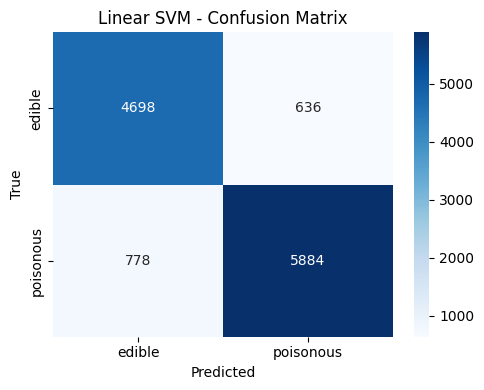

In [ ]:
# Confusion matrix plot
svc_cm = plot_confusion_matrix(svc_pred, title="Linear SVM - Confusion Matrix")

**!Conclusion:**
The confusion matrix shows that the Linear SVM makes a noticeable number of mistakes in both classes, with slightly more poisonous mushrooms misclassified as edible than the reverse. Overall, the model provides reasonable separation but still produces many borderline errors compared to the tree-based models.

#### 8.2.5. ROC Curve

This cell builds the ROC curve for the Linear SVM by collecting the model’s raw decision scores (margin) for the positive class (p = 1) from rawPrediction together with the true labels, then sweeping decision thresholds to compute TPR vs. FPR and the AUC summary score.

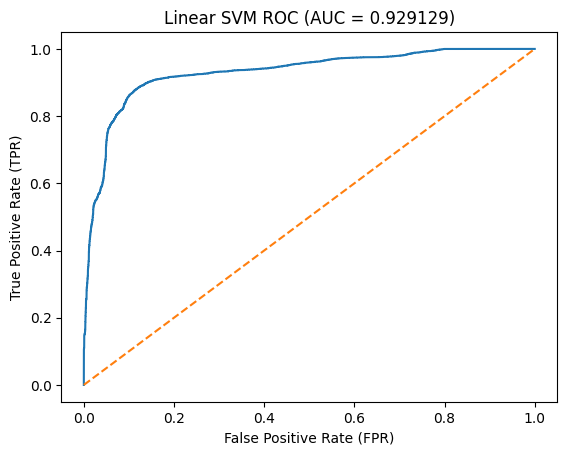

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

scores_labels = (
    svc_pred.select(
        vector_to_array("rawPrediction").getItem(1).alias("score"),
        F.col("label").cast("double").alias("label")
    )
    .rdd.map(lambda r: (float(r["score"]), float(r["label"])))
    .collect()
)

y_score = [s for s, y in scores_labels]
y_true  = [y for s, y in scores_labels]

fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1.0)
roc_auc_svc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"Linear SVM ROC (AUC = {roc_auc_svc:.6f})")
plt.show()


**!Conclusion:**

The Linear SVM ROC curve lies clearly above the random baseline and achieves an AUC ≈ 0.929, indicating strong ability to distinguish poisonous (p=1) from edible (e=0) mushrooms. However, compared to the tree-based models (DT/RF/GBT), the curve is less concentrated near the top-left corner, meaning the SVM generally requires a slightly higher false positive rate to reach very high true positive rates, so its discrimination is good but not near-perfect.

In [52]:
# Adding the SVC Results to the all_models list
svc_results = {"model": "Linear SVM", "test_acc": round(acc_svc * 100, 3), "test_f1": round(f1_svc, 5), "roc_auc": round(float(roc_auc_svc),3)}
all_models.append(svc_results)

In [53]:
all_models

[{'model': 'Logistic Regression',
  'test_acc': 86.696,
  'test_f1': 0.86709,
  'roc_auc': 0.936},
 {'model': 'Linear SVM',
  'test_acc': 88.213,
  'test_f1': 0.88227,
  'roc_auc': 0.929}]

### 8.3. Naive Bayes Classifier

#### 8.3.1. Naive Bayes Preprocessing Pipeline

In this step, I define a preprocessing pipeline specifically for **Naive Bayes**. Spark’s Naive Bayes requires a non-negative feature vector, so I keep the preprocessing simple: I impute missing numeric values using the median, convert categorical columns to indices with `StringIndexer`, apply one-hot encoding with `OneHotEncoder`, and finally combine all processed features into a single `features` vector using `VectorAssembler`. This pipeline produces a model-ready representation without standardization, which avoids negative values that would violate Naive Bayes assumptions.


In [32]:
imputer_nb = Imputer(
    inputCols=num_cols,
    outputCols=[f"{c}_imp" for c in num_cols]
).setStrategy("median")
num_imp_cols = [f"{c}_imp" for c in num_cols]

indexers_nb = [StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="keep") for c in cat_cols]
idx_cols_nb = [f"{c}_idx" for c in cat_cols]

encoder_nb = OneHotEncoder(
    inputCols=idx_cols_nb,
    outputCols=[f"{c}_ohe" for c in cat_cols],
    handleInvalid="keep"
)
ohe_cols_nb = [f"{c}_ohe" for c in cat_cols]

assembler_nb = VectorAssembler(inputCols=num_imp_cols + ohe_cols_nb, outputCol="features")

prep_pipeline_nb = Pipeline(stages=[imputer_nb] + indexers_nb + [encoder_nb, assembler_nb])


#### 8.3.2. Training the Naive Bayes Pipeline

In this step, I train a **Naive Bayes** classifier using Spark ML. I use the **multinomial** variant, which is commonly applied to count-like or non-negative feature vectors and works well with one-hot encoded categorical variables. I then combine the Naive Bayes classifier with the Naive Bayes–compatible preprocessing pipeline in a single `Pipeline` and fit it on the training split to obtain a fully trained model ready for prediction.


In [33]:
# Define Naive Bayes classifier
nb = NaiveBayes(
    labelCol="label",
    featuresCol="features",
    modelType="multinomial",
    smoothing= 1.0
)

# Full pipeline: preprocessing + model
nb_model = Pipeline(stages=prep_pipeline_nb.getStages() + [nb])

# Fit on training data
nb_fitted = nb_model.fit(train_df)

#### 8.3.3. Feature Discriminativeness (Naive Bayes)

Naive Bayes does not provide feature importances or coefficients in the same way as tree-based or linear models. Instead, I measure how strongly each feature separates the two classes by comparing the learned log-conditional probabilities for class 0 vs. class 1 (based on \|Δ log P(x|class)|\). I aggregate these scores back to the original feature level (grouping one-hot encoded dimensions), normalize them to percentages, and then display and plot the top 20 most discriminative features.



Naive Bayes: Feature Discriminativeness by Class (%)
Feature                Score (%)
--------------------------------
veil-color                 15.79
spore-print-color          13.92
stem-surface               12.29
stem-root                  11.56
stem-color                 10.91
habitat                     9.87
ring-type                   8.31
cap-color                   4.53
cap-surface                 3.52
gill-color                  3.03
gill-attachment             1.98
cap-shape                   1.71
season                      0.80
gill-spacing                0.68
veil-type                   0.45
has-ring                    0.28
does-bruise-or-bleed        0.17
stem-width                  0.09
cap-diameter                0.07
stem-height                 0.02


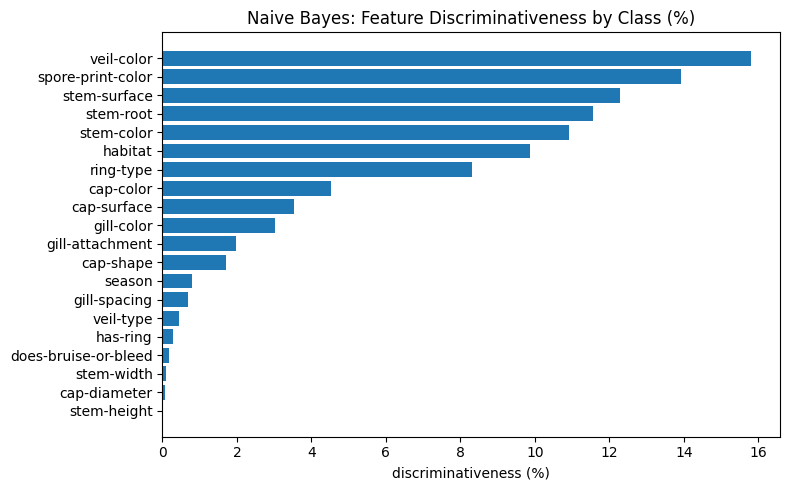

In [ ]:
nb_items = nb_feature_discriminativeness(nb_fitted, top_m=20, plot=True, title="Naive Bayes: Feature Discriminativeness by Class (%)")

**!Conclusion:**
Naive Bayes finds **veil-color** and **spore-print-color** to be the most discriminative attributes, followed by several stem-related features (stem-surface/root/color) and habitat. Overall, the separation power is driven mainly by categorical variables, while the numeric size measurements contribute very little to class discrimination in this model.

#### 8.3.4. Predicting on the Test Set

After fitting the Naive Bayes pipeline, I generate predictions on the held-out test set using `transform()`. I then evaluate performance using Spark’s evaluators, reporting **test accuracy** and **F1-score**. Finally, I compute the **training accuracy** on the training split as a simple generalization check by comparing it with the test performance.


In [34]:
# Predict on test set
nb_pred = nb_fitted.transform(test_df)

# Metrics (accuracy + F1)
acc_eval = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
f1_eval  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")

acc_nb = acc_eval.evaluate(nb_pred)
f1_nb  = f1_eval.evaluate(nb_pred)

print(f"Test Accuracy : {acc_nb * 100:.3f}%")
print(f"Test F1-score  : {f1_nb:.5f}")

Test Accuracy : 76.050%
Test F1-score  : 0.75965


In [ ]:
# Train accuracy
nb_pred_train = nb_fitted.transform(train_df)
acc_nb_train = acc_eval.evaluate(nb_pred_train)
print(f"Train accuracy: {acc_nb_train * 100:.3f}%")

Train accuracy: 76.183%


**!Conclusion:**
Naive Bayes achieves relatively low performance on this dataset (≈76.05% test accuracy, F1 ≈0.760). The training and test accuracies are very close, indicating stable generalization, but the model’s simplifying independence assumptions limit its predictive power compared to Logistic Regression and Linear SVM.

#### 8.3.5. Confusion Matrix

To complement the evaluation metrics, I plot the **confusion matrix** for Naive Bayes predictions. This visualization shows how many edible and poisonous mushrooms are classified correctly and highlights the types of errors (false positives vs. false negatives). It provides a clearer view of model behavior beyond overall accuracy.

Accuracy : 76.050%
F1-score  : 0.75965
Precision : 0.77185
Recall    : 0.80742



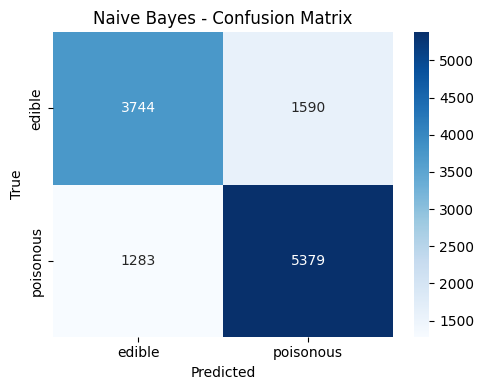

In [ ]:
# Confusion matrix + precision/recall
nb_cm = plot_confusion_matrix(nb_pred, title="Naive Bayes - Confusion Matrix")

**!Conclusion:**
The confusion matrix shows that Naive Bayes makes a large number of errors in both directions, with many edible mushrooms predicted as poisonous and many poisonous mushrooms predicted as edible. This confirms the weaker overall performance of Naive Bayes on this dataset compared to the other classifiers.

#### 8.3.6. ROC Curve

In this section, I evaluate the Naive Bayes classifier using the ROC curve, which shows how the True Positive Rate (TPR) changes against the False Positive Rate (FPR) as I vary the decision threshold. I extract the model’s predicted probability for the positive class (p = 1) from Spark’s probability output, then compute the ROC points and the AUC score to summarize how well Naive Bayes separates poisonous from edible mushrooms across all thresholds.

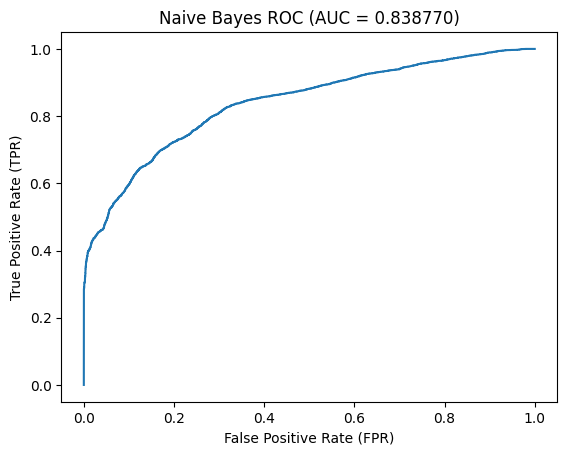

In [39]:
from sklearn.metrics import roc_curve, auc

scores_labels = (
    nb_pred.select("probability", "label")
          .rdd
          .map(lambda r: (float(r["probability"][1]), float(r["label"])))
          .collect()
)

y_score = [s for s, y in scores_labels]
y_true  = [y for s, y in scores_labels]

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1.0)
roc_auc_nb = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"Naive Bayes ROC (AUC = {roc_auc_nb:.6f})")
plt.show()

**!CONCLUSION:**

The Naive Bayes ROC curve stays above the random baseline and achieves an AUC ≈ 0.839, indicating moderate-to-good ability to distinguish poisonous (p=1) from edible (e=0) mushrooms. However, the curve is noticeably farther from the top-left corner than the stronger models (e.g., RF/GBT/DT), meaning Naive Bayes typically needs a higher false positive rate to reach high true positive rates, so its overall discrimination performance is weaker in comparison.

In [54]:
# Adding the Naive Base Results to the all_models list
nb_results = {"model": "Naive Bayes", "test_acc": round(acc_nb * 100, 3), "test_f1": round(f1_nb, 5), "roc_auc": round(float(roc_auc_nb), 3)}
all_models.append(nb_results)

In [55]:
all_models

[{'model': 'Logistic Regression',
  'test_acc': 86.696,
  'test_f1': 0.86709,
  'roc_auc': 0.936},
 {'model': 'Linear SVM',
  'test_acc': 88.213,
  'test_f1': 0.88227,
  'roc_auc': 0.929},
 {'model': 'Naive Bayes',
  'test_acc': 76.05,
  'test_f1': 0.75965,
  'roc_auc': 0.839}]

## 9. Final Conclusion (Model Comparison)

In this final section, I summarize the results of all trained models. First, I print a compact comparison table containing each classifier’s **test accuracy** and **test F1-score**. Then, I visualize these metrics using side-by-side bar charts to make performance differences easier to interpret at a glance. This final comparison helps me identify which model provides the best overall predictive performance on the held-out test set.


In [ ]:
print_all_models_table(all_models)

Model                Test Accuracy (%)  Test F1
-----------------------------------------------
Logistic Regression             86.696  0.86709
Linear SVM                      88.213  0.88227
Naive Bayes                     76.050  0.75965


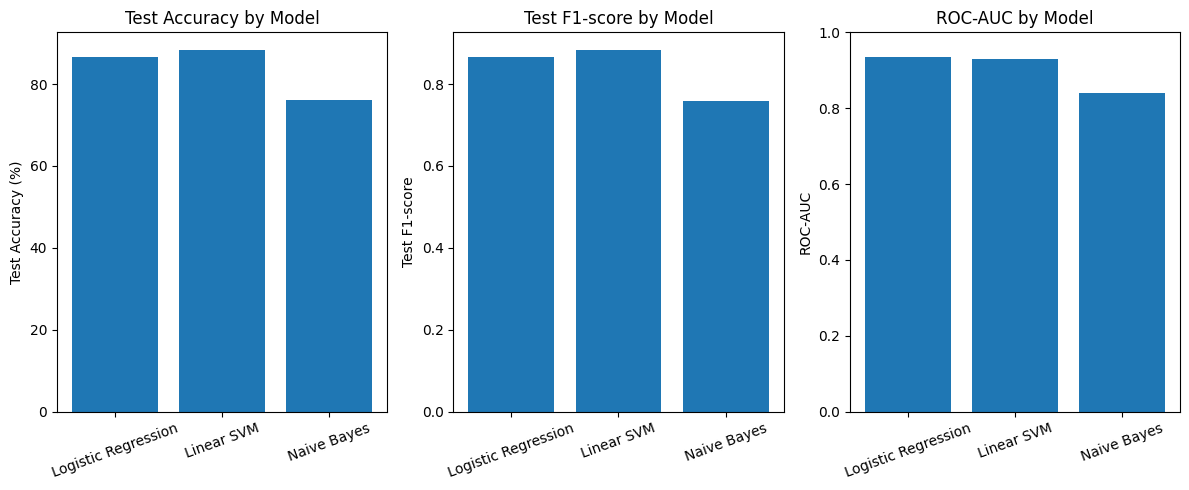

In [61]:
# Prepare arrays for plotting
models = [row["model"] for row in all_models]
accs   = [row["test_acc"] for row in all_models]
f1s    = [row["test_f1"] for row in all_models]
aucs   = [row["roc_auc"] for row in all_models]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# Accuracy plot
axes[0].bar(models, accs)
axes[0].set_title("Test Accuracy by Model")
axes[0].set_ylabel("Test Accuracy (%)")
axes[0].tick_params(axis="x", rotation=20)

# F1 plot
axes[1].bar(models, f1s)
axes[1].set_title("Test F1-score by Model")
axes[1].set_ylabel("Test F1-score")
axes[1].tick_params(axis="x", rotation=20)

# ROC-AUC plot
axes[2].bar(models, aucs)
axes[2].set_title("ROC-AUC by Model")
axes[2].set_ylabel("ROC-AUC")
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis="x", rotation=20)

plt.tight_layout()
plt.show()

**!Final Conclusion:**

Based on the test-set results, Linear SVM performs best overall, achieving the highest accuracy (≈88.2%) and F1-score (≈0.88), and it also shows strong discriminative ability with a high ROC–AUC (≈0.93). Logistic Regression follows closely with ≈86.7% accuracy, ≈0.87 F1, and a slightly higher ROC–AUC (≈0.94), indicating that it ranks poisonous vs. edible cases very well across thresholds even though its default-threshold classification metrics are marginally lower than SVM. Naive Bayes is the weakest of the three, with the lowest accuracy (≈76.1%), F1 (≈0.76), and ROC–AUC (≈0.84), suggesting its conditional-independence assumption is too restrictive for this dataset. Overall, the ROC–AUC comparison confirms that the two linear models separate the classes much better than Naive Bayes, while their close performance indicates that a linear decision boundary captures a large part of the structure in the data.

## Short Comparison Across All 6 Models

When I compare these three models with the tree-based notebook, the difference is clear: tree-based methods dominate on this dataset.

* GBT (99.975% accuracy, 0.99975 F1) is the strongest overall, followed by Decision Tree (99.792%, 0.99792) and Random Forest (99.250%, 0.99250).

* In contrast, the best linear/probabilistic model (Linear SVM at 88.213%) is far below even the weakest tree model (Random Forest at 99.250%).

This strongly suggests that the mushroom dataset contains non-linear interactions between categorical attributes, which tree ensembles (especially boosting) model very effectively, while linear models and Naive Bayes cannot capture as well.